In [1]:
from __future__ import print_function, division
import numpy as np
import functools
import matplotlib.pyplot as plt
import time
import xgboost as xgb

/home/giodiro/source/ml/venv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
matrix_size = (10000, 1000)
## Helper functions
def extract_line_data(l):
    us = l.index('_')
    row = int(l[1:us])-1
    com = l.index(',')
    col = int(l[us+2:com])-1
    val = float(l[com+1:l.index('\n')])
    return (row, col, val)
    
def read_data(file_name):
    print("Reading file %s" % file_name)
    Atr = np.zeros(matrix_size, dtype=float)
    
    with open(file_name, 'r') as fh:
        data = fh.readlines()
    
    for i, l in enumerate(data[1:]):
        row, col, val = extract_line_data(l)
        Atr[row, col] = val

    return Atr

def write_predict(pfunc, M, fn):
    with open(fn, 'w') as fh:
        fh.write("Id,Prediction\n")
        for x in range(M.shape[0]):
            for y in range(M.shape[1]):
                if M[x, y] == True:
                    fh.write("r%d_c%d,%f\n" % (x+1, y+1, pfunc(x, y)))

In [3]:
do_predictions = True

In [4]:
# Read true training labels
train_labels = read_data("data_train.csv")
test_labels = read_data("sampleSubmission.csv")

Reading file data_train.csv
Reading file sampleSubmission.csv


In [5]:
# Split validation and training
train_indices = np.array(np.where(train_labels != 0)).T
if do_predictions:
    valid_size = 0
else:
    valid_size = train_indices.shape[0]//4

valid_indices_tmp = np.random.choice(range(train_indices.shape[0]), 
                                     size=(valid_size, ), 
                                     replace=False)
valid_indices = np.array(train_indices[valid_indices_tmp,:])
train_indices = np.delete(train_indices, valid_indices_tmp, axis=0)

In [6]:
## Read data into xgboost matrices
load_from_disk = False
predictor_files = [
  #"./saved_data/predictors/_Bias_test.csv",  "./saved_data/predictors/_Bias_train.csv",
  "./saved_data/predictors/_SVD_test.csv",          "./saved_data/predictors/_SVD_train.csv",
  "./saved_data/predictors/_simple_test.csv",     "./saved_data/predictors/_simple_train.csv",
  "./saved_data/predictors/_SGD++_test.csv",         "./saved_data/predictors/_SGD++_train.csv",
  "./saved_data/predictors/_Neighbourhood_pearson_test.csv", "./saved_data/predictors/_Neighbourhood_pearson_train.csv",
  "./saved_data/predictors/_Integrated_pearson_test.csv",         "./saved_data/predictors/_Integrated_pearson_train.csv",
  "./saved_data/predictors/autoenc_ax0_pred_test.csv", "./saved_data/predictors/autoenc_ax0_pred_train.csv",
  "./saved_data/predictors/autoenc_ax1_pred_test.csv", "./saved_data/predictors/autoenc_ax1_pred_train.csv",
]
# Read feature vectors from disk
train_stack = []
test_stack  = []
valid_stack = []
#valid_labels = 
for pf in predictor_files:
    data = read_data(pf)
    if "train" in pf:
        flat_tr_data = data[tuple([train_indices[:,0], train_indices[:,1]])]
        train_stack.append(flat_tr_data)
        flat_vl_data = data[tuple([valid_indices[:,0], valid_indices[:,1]])]
        valid_stack.append(flat_vl_data)
    elif "test" in pf:
        flat_data = data[np.where(test_labels != 0)]
        test_stack.append(flat_data)
    else:
        print("Unknown file: %s" % pf)



Reading file ./saved_data/predictors/_SVD_test.csv
Reading file ./saved_data/predictors/_SVD_train.csv
Reading file ./saved_data/predictors/_simple_test.csv
Reading file ./saved_data/predictors/_simple_train.csv
Reading file ./saved_data/predictors/_SGD++_test.csv
Reading file ./saved_data/predictors/_SGD++_train.csv
Reading file ./saved_data/predictors/_Neighbourhood_pearson_test.csv
Reading file ./saved_data/predictors/_Neighbourhood_pearson_train.csv
Reading file ./saved_data/predictors/_Integrated_pearson_test.csv
Reading file ./saved_data/predictors/_Integrated_pearson_train.csv
Reading file ./saved_data/predictors/autoenc_ax0_pred_test.csv
Reading file ./saved_data/predictors/autoenc_ax0_pred_train.csv
Reading file ./saved_data/predictors/autoenc_ax1_pred_test.csv
Reading file ./saved_data/predictors/autoenc_ax1_pred_train.csv


In [8]:
user_mean = np.empty_like(train_labels, dtype="float32")
item_mean = np.empty_like(train_labels, dtype="float32")
item_counts = np.empty_like(train_labels, dtype="float32")
user_counts = np.empty_like(train_labels, dtype="float32")
for u in range(matrix_size[0]):
    user_mean[u,:] = np.mean(train_labels[u,:][train_labels[u,:] != 0])
for u in range(matrix_size[0]):
    user_counts[u,:] = len(train_labels[u,:][train_labels[u,:] != 0])
for i in range(matrix_size[1]):
    item_mean[:,i] = np.mean(train_labels[:,i][train_labels[:,i] != 0])
for i in range(matrix_size[1]):
    item_counts[:,i] = len(train_labels[:,i][train_labels[:,i] != 0])

In [12]:
print(np.mean(train_stack))
print(np.mean(new_train))

3.84948579484
-9.95197126195e-17


In [13]:
train_stack.append(user_mean[tuple([train_indices[:,0], train_indices[:,1]])])
train_stack.append(user_counts[tuple([train_indices[:,0], train_indices[:,1]])])
train_stack.append(item_mean[tuple([train_indices[:,0], train_indices[:,1]])])
train_stack.append(item_counts[tuple([train_indices[:,0], train_indices[:,1]])])
test_stack.append(user_mean[np.where(test_labels != 0)])
test_stack.append(user_counts[np.where(test_labels != 0)])
test_stack.append(item_mean[np.where(test_labels != 0)])
test_stack.append(item_counts[np.where(test_labels != 0)])

In [14]:
global_mean = np.empty_like(train_labels, dtype="float32")
global_mean[:,:] = np.mean(train_labels[train_labels != 0])

train_stack.append(global_mean[tuple([train_indices[:,0], train_indices[:,1]])])
test_stack.append(global_mean[np.where(test_labels != 0)])

In [15]:
user_var = np.empty_like(train_labels, dtype="float32")
item_var = np.empty_like(train_labels, dtype="float32")
for u in range(matrix_size[0]):
    user_var[u,:] = np.var(train_labels[u,:][train_labels[u,:] != 0])
for i in range(matrix_size[1]):
    item_var[:,i] = np.var(train_labels[:,i][train_labels[:,i] != 0])
train_stack.append(user_var[tuple([train_indices[:,0], train_indices[:,1]])])
train_stack.append(item_var[tuple([train_indices[:,0], train_indices[:,1]])])
test_stack.append(user_var[np.where(test_labels != 0)])
test_stack.append(item_var[np.where(test_labels != 0)])


In [16]:
x_train = np.vstack(train_stack).T
print(x_train.shape)
y_train = train_labels[tuple([train_indices[:,0], train_indices[:,1]])]
print(y_train.shape)

if do_predictions:
    x_test = np.vstack(test_stack).T
    print(x_test.shape)
    y_test = None
else:
    x_test = np.vstack(valid_stack).T
    print(x_test.shape)
    y_test = train_labels[tuple([valid_indices[:,0], valid_indices[:,1]])]
    print(y_test.shape)


(1176952, 14)
(1176952,)
(1176952, 14)


In [42]:
""" Standardize predictors for regression
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

sc_x_train = scaler.fit_transform(x_train)
sc_x_test = scaler.transform(x_test)
sc_y_train = scaler.fit_transform(y_train[:,None])[:,0]

In [40]:
""" Perform ridge regression as an ensemble model
"""
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
## Least squares
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

ridge = Ridge(alpha=1.5, fit_intercept=True, normalize=False)
scorer = make_scorer(RMSE, greater_is_better=False)
cvs = cross_val_score(ridge, sc_x_train, sc_y_train, cv=5, n_jobs=-1, scoring=scorer)
print("5-fold CV score: %f +- %f" % (-np.mean(cvs), np.std(cvs)))
ridge.fit(sc_x_train, sc_y_train)
pred = ridge.predict(sc_x_test)
pred = scaler.inverse_transform(pred[:,None])[:,0]
for i in range(len(pred)):
    if pred[i] < 1: pred[i] = 1
    elif pred[i] > 5: pred[i] = 5


5-fold CV score: 0.682173 +- 0.003400


In [40]:
""" CV doesn't work:(
"""
for alpha in [0, 0.01, 0.1, 1, 10, 100]:
    ridge = Ridge(alpha=alpha, fit_intercept=True, normalize=True)
    cvs = cross_val_score(ridge, x_train, y_train, cv=10, n_jobs=-1, scoring=scorer)
    print("5-fold CV score with alpha=%f: %f +- %f" % (alpha, -np.mean(cvs), np.std(cvs)))

5-fold CV score with alpha=0.000000: 0.763348 +- 0.005233
5-fold CV score with alpha=0.010000: 0.768207 +- 0.005717
5-fold CV score with alpha=0.100000: 0.802070 +- 0.006053
5-fold CV score with alpha=1.000000: 0.871382 +- 0.005686
5-fold CV score with alpha=10.000000: 0.971308 +- 0.005893
5-fold CV score with alpha=100.000000: 1.090060 +- 0.006317


In [41]:
""" Write submission to file
"""
submit_file = "./saved_data/submit_ridgereg.csv"
print("Writing results to %s" % submit_file)
with open(submit_file, 'w') as fh:
    fh.write("Id,Prediction\n")
    indices = np.where(test_labels != 0)
    for index in range(len(indices[0])):
        u = indices[0][index]
        i = indices[1][index]
        fh.write("r%d_c%d,%f\n" % (u+1, i+1, pred[index]))

Writing results to ./saved_data/submit_ridgereg.csv


In [23]:
""" From here onwards tentative of using xgboost, failed due to lack of valid cross-validation!
"""
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_test, label=y_test)

In [142]:
d_train = xgb.DMatrix("saved_data/train.buffer")
d_valid = xgb.DMatrix("saved_data/valid.buffer")

In [10]:
print(d_train.get_label().shape)
print(d_valid.get_label().shape)

(882714,)
(294238,)


In [24]:
## XGBoost run
params = {}
params['objective'] = "reg:linear"
params['base_score'] = np.mean(y_train)
params['eval_metric'] = "rmse"
params['seed'] = 123912
params['eta'] = 0.1
params['max_depth'] = 4
params['min_child_weight'] = 2
params['alpha'] = 10
params['lambda'] = 10
params['subsample'] = 0.1
num_round = 200
early_stop = 20

watchlist = [(d_train, 'train')]
if not do_predictions:
    watchlist.append((d_valid, 'valid'))
# Perform training.
bst = xgb.train(params, d_train, num_round, watchlist, early_stopping_rounds=early_stop, verbose_eval=10)

#if not do_predictions:
#    cvresult = xgb.cv(params, d_train, num_boost_round=num_round, nfold=5,
#            metrics='rmse', early_stopping_rounds=early_stop, verbose_eval=10)


[0]	train-rmse:1.07056
Will train until train-rmse hasn't improved in 20 rounds.
[10]	train-rmse:0.859288
[20]	train-rmse:0.818638
[30]	train-rmse:0.803657
[40]	train-rmse:0.79679
[50]	train-rmse:0.792608
[60]	train-rmse:0.7893
[70]	train-rmse:0.786584
[80]	train-rmse:0.784191
[90]	train-rmse:0.781962
[100]	train-rmse:0.780204
[110]	train-rmse:0.778899
[120]	train-rmse:0.777666
[130]	train-rmse:0.776754
[140]	train-rmse:0.775787
[150]	train-rmse:0.774933
[160]	train-rmse:0.774274
[170]	train-rmse:0.773623
[180]	train-rmse:0.773202
[190]	train-rmse:0.772819


In [155]:
xgb.cv(params, d_train, num_boost_round=num_round, nfold=5,
            metrics='rmse', early_stopping_rounds=early_stop, verbose_eval=10)

[0]	train-rmse:3.21031+0.000199725	test-rmse:3.21031+0.00133591
[10]	train-rmse:1.38993+0.000128936	test-rmse:1.38997+0.00117125
[20]	train-rmse:0.922725+0.000240366	test-rmse:0.922861+0.000818345
[30]	train-rmse:0.8331+0.000207216	test-rmse:0.833281+0.000854566


KeyboardInterrupt: 

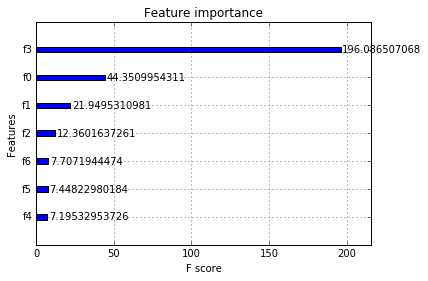

In [56]:
# TODO: find a way to get the names of the features!
xgb.plot_importance(bst, importance_type="gain")#, max_num_features=None)
plt.show()

In [25]:
# Make predictions
ypred = bst.predict(d_valid)
submit_file = "./saved_data/submit_xgboost.csv"
print("Writing results to %s" % submit_file)
with open(submit_file, 'w') as fh:
    fh.write("Id,Prediction\n")
    indices = np.where(test_labels != 0)
    for index in range(len(indices[0])):
        u = indices[0][index]
        i = indices[1][index]
        fh.write("r%d_c%d,%f\n" % (u+1, i+1, ypred[index]))

Writing results to ./saved_data/submit_xgboost.csv


In [58]:
# Stochastic Gradient Boosting Classification
import pandas
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier

In [64]:
seed = 7
num_trees = 5
kfold = model_selection.KFold(n_splits=4, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, x_train[:,1:], y_train, cv=kfold, verbose=10, n_jobs=2)
print(results.mean())

[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.456600, total=  44.4s
[CV]  ................................................................


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   44.7s


[CV] ................................. , score=0.459804, total=  45.1s
[CV]  ................................................................


[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:   45.3s remaining:   45.3s


[CV] ................................. , score=0.470523, total=  38.8s
[CV] ................................. , score=0.475335, total=  40.4s
0.465565307367


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1.4min finished
